In [2]:
# imports
import pystac_client
import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import pandas as pd

In [3]:
# Opening STAC catalog, either a url, cloud storage link or a local (cloned) folder
# File path
file_path_catalog = "https://storage.googleapis.com/dgds-data-public/gca/gca-stac/catalog.json" # cloud API

# Open catalog
catalog = pystac_client.Client.open(file_path_catalog)

# Print catalog
catalog

c:\Users\white_rn\AppData\Local\mambaforge\envs\gca_env\Lib\site-packages\pystac_client\client.py:187: NoConformsTo: Server does not advertise any conformance classes.
  warnings.warn(NoConformsTo())


<Client id=gca-catalog>

In [4]:
# Get all collections in the catalog
list(catalog.get_children())

[<CollectionClient id=shore_mon_fut>,
 <CollectionClient id=sed_class>,
 <CollectionClient id=shore_mon>,
 <CollectionClient id=world_pop>,
 <CollectionClient id=world_gdp>,
 <CollectionClient id=shore_mon_hr>,
 <CollectionClient id=shore_mon_drivers>,
 <CollectionClient id=esl_gwl>,
 <CollectionClient id=waves_by_cowclip>,
 <CollectionClient id=waves_by_cowclip>,
 <CollectionClient id=waves_by_cowclip>,
 <CollectionClient id=waves_by_cowclip>]

In [5]:
# Get hrefs for all items in the collection
waves_col = catalog.get_child("waves_by_cowclip")
waves_items = list(waves_col.get_items())
waves_hrefs = {item.assets["data"].href for item in waves_items}

c:\Users\white_rn\AppData\Local\mambaforge\envs\gca_env\Lib\site-packages\pystac_client\collection_client.py:145: FallbackToPystac: Falling back to pystac. This might be slow.
  root._warn_about_fallback("ITEM_SEARCH")


In [6]:
# Create dataframe with time, rcp, ens_perc, var_stat, var and href
waves_df = pd.DataFrame(columns=["time", "rcp", "ens_perc", "var_stat", "var", "href"], index=range(len(waves_hrefs)))
for i, href in enumerate(waves_hrefs):
    href_split = href.split("/")
    time = href_split[6].split('=')[1]
    rcp = href_split[7].split('=')[1]
    ens_perc = href_split[8].split('=')[1]
    var_stat = href_split[9].split('=')[1]
    var = href_split[10].split('.')[0]
    waves_df.loc[i] = [time, rcp, ens_perc, var_stat, var, href]

# Print dataframe
waves_df

,time,rcp,ens_perc,var_stat,var,href
0,2090,8.5,100,avg,Dm,https://storage.googleapis.com/dgds-data-publi...
1,1991,4.5,0,avg,Tm,https://storage.googleapis.com/dgds-data-publi...
2,2090,8.5,0,p10,Dm,https://storage.googleapis.com/dgds-data-publi...
3,1991,4.5,95,p90,Dm,https://storage.googleapis.com/dgds-data-publi...
4,2090,8.5,50,p50,Tm,https://storage.googleapis.com/dgds-data-publi...
...,...,...,...,...,...,...
475,2090,4.5,95,p99,Tm,https://storage.googleapis.com/dgds-data-publi...
476,1991,8.5,0,p95,Dm,https://storage.googleapis.com/dgds-data-publi...
477,2090,4.5,0,avg,Hs,https://storage.googleapis.com/dgds-data-publi...
478,2090,8.5,95,p90,Dm,https://storage.googleapis.com/dgds-data-publi...


In [7]:
# Filter dataframe if necessary
waves_df_ss = waves_df[(waves_df['time'] == '2090') & (waves_df['rcp'] == '8.5') & (waves_df['ens_perc'] == '50') & (waves_df['var_stat'] == 'avg')].reset_index(drop=True)
waves_df_ss = waves_df

# Print dataframe
waves_df_ss

,time,rcp,ens_perc,var_stat,var,href
0,2090,8.5,100,avg,Dm,https://storage.googleapis.com/dgds-data-publi...
1,1991,4.5,0,avg,Tm,https://storage.googleapis.com/dgds-data-publi...
2,2090,8.5,0,p10,Dm,https://storage.googleapis.com/dgds-data-publi...
3,1991,4.5,95,p90,Dm,https://storage.googleapis.com/dgds-data-publi...
4,2090,8.5,50,p50,Tm,https://storage.googleapis.com/dgds-data-publi...
...,...,...,...,...,...,...
475,2090,4.5,95,p99,Tm,https://storage.googleapis.com/dgds-data-publi...
476,1991,8.5,0,p95,Dm,https://storage.googleapis.com/dgds-data-publi...
477,2090,4.5,0,avg,Hs,https://storage.googleapis.com/dgds-data-publi...
478,2090,8.5,95,p90,Dm,https://storage.googleapis.com/dgds-data-publi...


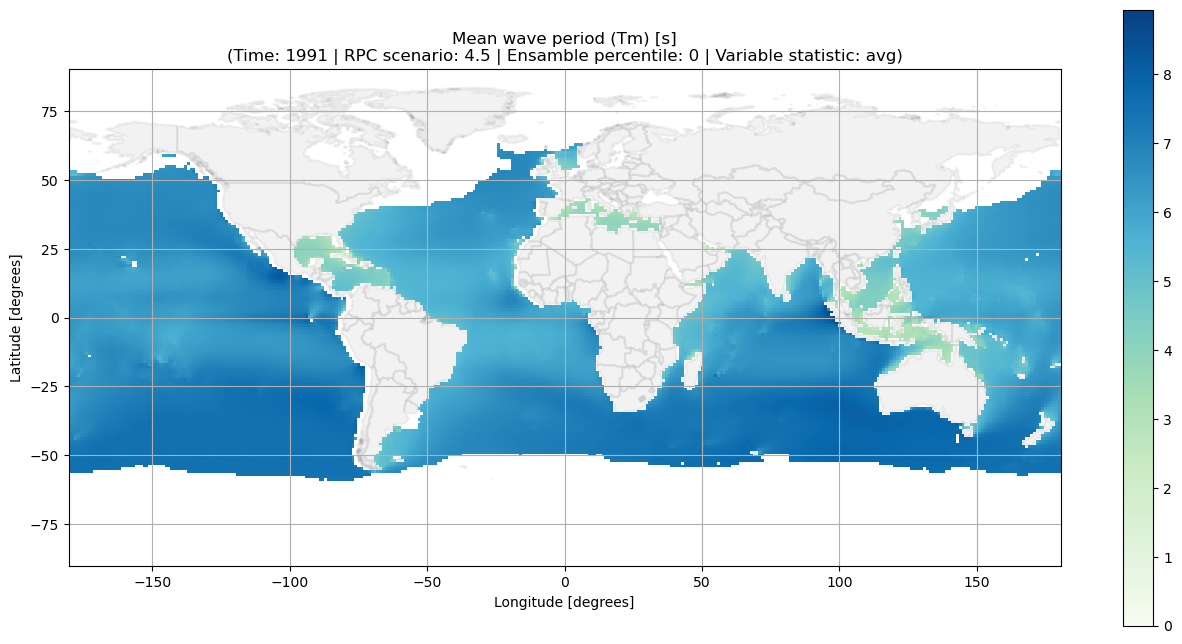

In [9]:
# Get data
idx = 1
ds = rxr.open_rasterio(waves_df_ss['href'][idx])

# Get world shapefile
shapefile = r'p:\11208003-latedeo2022\020_InternationalDeltaPortfolio\datasets\05_world-administrative-boundaries\world-administrative-boundaries.shp'
world = gpd.read_file(shapefile)

# Plotting parameters
vars = {'Tm': 'Mean wave period', 'Dm': 'Mean wave direction', 'Hs': 'Significant wave height'}
units = {'Tm': 's', 'Dm': 'degrees', 'Hs': 'm'}
cmaps = {'Tm': 'GnBu', 'Dm': 'hsv', 'Hs': 'Reds'}
vmin = {'Tm': 0, 'Dm': 0, 'Hs': None}
vmax = {'Tm': None, 'Dm': 360, 'Hs': None}

# Plot data
fig, ax = plt.subplots(figsize=(16, 8))
ds.plot(ax=ax, cmap=cmaps[waves_df_ss['var'][idx]], vmin=vmin[waves_df_ss['var'][idx]], vmax=vmax[waves_df_ss['var'][idx]])
world.boundary.plot(ax=ax, edgecolor='grey', facecolor='grey', alpha=0.1, zorder=0)
ax.set_aspect('equal')
ax.set_xlabel('Longitude [degrees]')
ax.set_ylabel('Latitude [degrees]')
ax.set_title('{} ({}) [{}]\n(Time: {} | RPC scenario: {} | Ensamble percentile: {} | Variable statistic: {})'.format(vars[waves_df_ss['var'][idx]], waves_df_ss['var'][idx], units[waves_df_ss['var'][idx]],
                                                                                                                          waves_df_ss['time'][idx], waves_df_ss['rcp'][idx], waves_df_ss['ens_perc'][idx], waves_df_ss['var_stat'][idx]))
ax.grid()
plt.show()